In [133]:
# This code will perform perform SVD on the A matrix and extract the relevant coherent structures

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

In [135]:
# Read Input
def read_variables_to_globals(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    for i in range(0, len(lines), 2):
        var_name = lines[i]
        raw_value = lines[i+1]

        try:
            value = int(raw_value)
        except ValueError:
            try:
                value = float(raw_value)
            except ValueError:
                value = raw_value

        globals()[var_name] = value  # Define variable in global scope

In [ ]:
# Perform SVD on a normal computer
# Compute Correlation matrix 
#   -> Compute eigenvectors (temporal modes) and square root of eigenvalues of correlation matrix (singular values)
#       -> Compute the leading k modes of U based on the desired input
def POD_regular(ProjectName, NumSS, NumModes):
    # NumSS == Number of Snapshots -> Determines how big the square matrix is 

    corr = np.zeros((NumSS, NumSS))  # Initialize correlation matrix
    ModeSize = 0 # Intialize the size of each mode

    # Perform every dot product combo on the column snapshots in order to build the correlation matrix
    for i in range(NumSS):
        for j in range(i, NumSS):  # j starts at i
            snap_id_a = i + 1
            snap_id_b = j + 1

            snap_filename_a = ProjectName + "_SnapShot_"  + str(snap_id_a) + ".txt"
            snap_filename_b = ProjectName + "_SnapShot_"  + str(snap_id_b) + ".txt"

            snap_a = np.loadtxt(snap_filename_a)
            snap_b = np.loadtxt(snap_filename_b)

            if i == 0 and j == 0:
                ModeSize = len(snap_a)

            corr[i, j] = np.dot(snap_a, snap_b) 
            corr[j, i] = corr[i, j]       # fill symmetric entry

    
    print("Number of Modes we want to compute:")
    print(NumModes)

    print("Size of each mode:")
    print(ModeSize)

    #print("Correlation Matrix By hand:")
    #print(corr)

    eig_corr, tempModes = eigsh(corr)
    print("Size of the eigenvalues")
    print(eig_corr.size)
    
    tempModes = tempModes[:, ::-1]  # Flip columns

    Vt = np.transpose(tempModes)
    S = np.sqrt(eig_corr)
    S = S[::-1]

    print("S =", S)
    print("V^T =", Vt)

    U = np.zeros((ModeSize, NumModes))

    for k in range(NumModes): # Loop to calculate each mode: A*V*sigma^-1
        mode_init = np.zeros(ModeSize)
        # Loop over all snapshots to perform A*V
        for i in range(NumSS):
            snapshot_id = i + 1
            snap_filename = ProjectName + "_SnapShot_"  + str(snapshot_id) + ".txt"
            snapshot = np.loadtxt(snap_filename)
            
            mode_init = mode_init + snapshot*Vt[k,i]*S[k]**(-1)

        U[:, k] = mode_init

    print("From manual:")
    #print("U =", U)
    #print("S =", S)
    #print("V^T =", Vt)

    # # Validate Correlation Matrix through direct computation
    # snapshot_mat_full =  np.loadtxt("ToyData_Snapshot_Mat.txt")
    # corr_val = np.dot(np.transpose(snapshot_mat_full), snapshot_mat_full)

    # print("Correlation Matrix for Validation:")
    # print(corr_val)

    return U, S, Vt

In [137]:
# This Block is for validating the above block to make sure that what it is outputting makes sense
def POD_regular_validate(ProjectName):
    SnapShotMat_filename = ProjectName + "_SnapShot_Mat.txt"
    SnapShot_Mat = np.loadtxt(SnapShotMat_filename)
    U, S, Vt = np.linalg.svd(SnapShot_Mat, full_matrices=False)
    print("From validation:")
    #print("U =", U)
    print("S =", S)
    #print("V^T =", Vt)
    return U, S, Vt

In [138]:
# TODO: Spectral POD (sPOD) Calculation
# 

In [139]:
# Percentage of Energy Captured from k rank approximation
def energy_captured(S, NumModes):
    energy_ratio = np.sum(S[:NumModes]**2) / np.sum(S**2)
    return energy_ratio

In [140]:
# Plot Log of normalized singular values
def plot_singular(S, titlename):
    # Create the plot

    x = np.arange(1, len(S) + 1)
    plt.plot(x, np.log10(S / np.max(S)))

    # Add labels and title
    plt.xlabel('Singular Values')
    plt.ylabel('Log of Normalized Singular Values')
    plt.title(titlename)

    # Show the plot
    plt.show()

In [141]:
# Plot the temporal modes
def plot_temporal_modes(Vt, NumModes):
    """
    Plots the first NumModes temporal modes from Vt (rows of Vt).
    
    Parameters:
    - Vt: 2D numpy array (shape: NumModes x NumSnapshots)
    - NumModes: number of leading modes to plot
    """
    fig, axs = plt.subplots(NumModes, 1, figsize=(8, 2.5 * NumModes), sharex=True)

    if NumModes == 1:
        axs = [axs]  # wrap single axis in list for consistency

    for i in range(NumModes):
        axs[i].plot(Vt[i], linewidth=2)
        axs[i].set_title(f"Temporal Mode {i+1}", fontsize=12)
        axs[i].set_ylabel("Amplitude")
        axs[i].grid(True)

    axs[-1].set_xlabel("Snapshot time index (temporary)")
    plt.tight_layout()
    plt.show()

In [142]:
def main(ProjectName, NumSS, NumModes):
    # SVD for computation of 
    U, S, Vt = POD_regular(ProjectName, NumSS, NumModes)
    # SVD on complete matrix for validation
    U_val, S_val, Vt_val = POD_regular_validate(ProjectName)

    # Spectral POD Computation

    return U, S, Vt, U_val, S_val, Vt_val

Number of Modes we want to compute:
6
Size of each mode:
100000
Correlation Matrix By hand:
[[3858854. 3030249. 3040905. ... 3022426. 3040078. 3030887.]
 [3030249. 3848340. 3038917. ... 3022322. 3025210. 3029920.]
 [3040905. 3038917. 3876820. ... 3033560. 3047998. 3040098.]
 ...
 [3022426. 3022322. 3033560. ... 3842156. 3030808. 3025939.]
 [3040078. 3025210. 3047998. ... 3030808. 3864339. 3039295.]
 [3030887. 3029920. 3040098. ... 3025939. 3039295. 3860318.]]
Size of the eigenvalues
6
S = [17418.89471575   936.4331867    934.5056739    933.53623676
   933.19042544   931.9176891 ]
V^T = [[ 0.10009495  0.09993645  0.10046585  0.10034508  0.09975925  0.09996774
   0.10000764  0.10012621  0.09992643  0.09991405  0.09988161  0.09956256
   0.10000721  0.0998003   0.09984196  0.10026127  0.10005593  0.09981597
   0.09991564  0.09986794  0.10032618  0.09992672  0.09988281  0.099731
   0.10009491  0.09961681  0.0998785   0.10022829  0.10018314  0.10012645
   0.09999932  0.10021989  0.09990924  

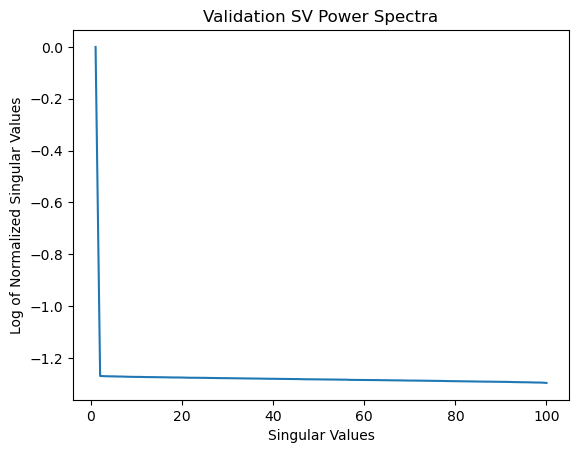

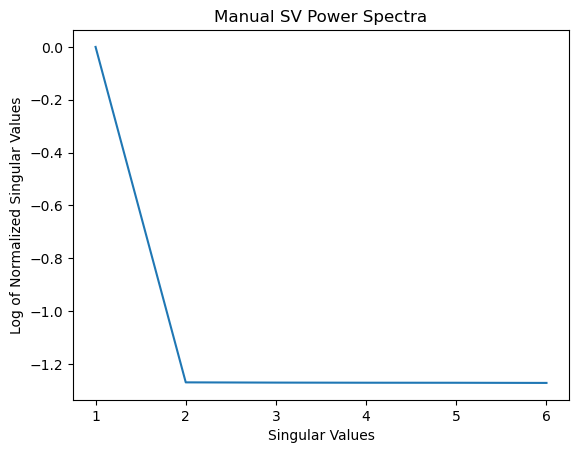

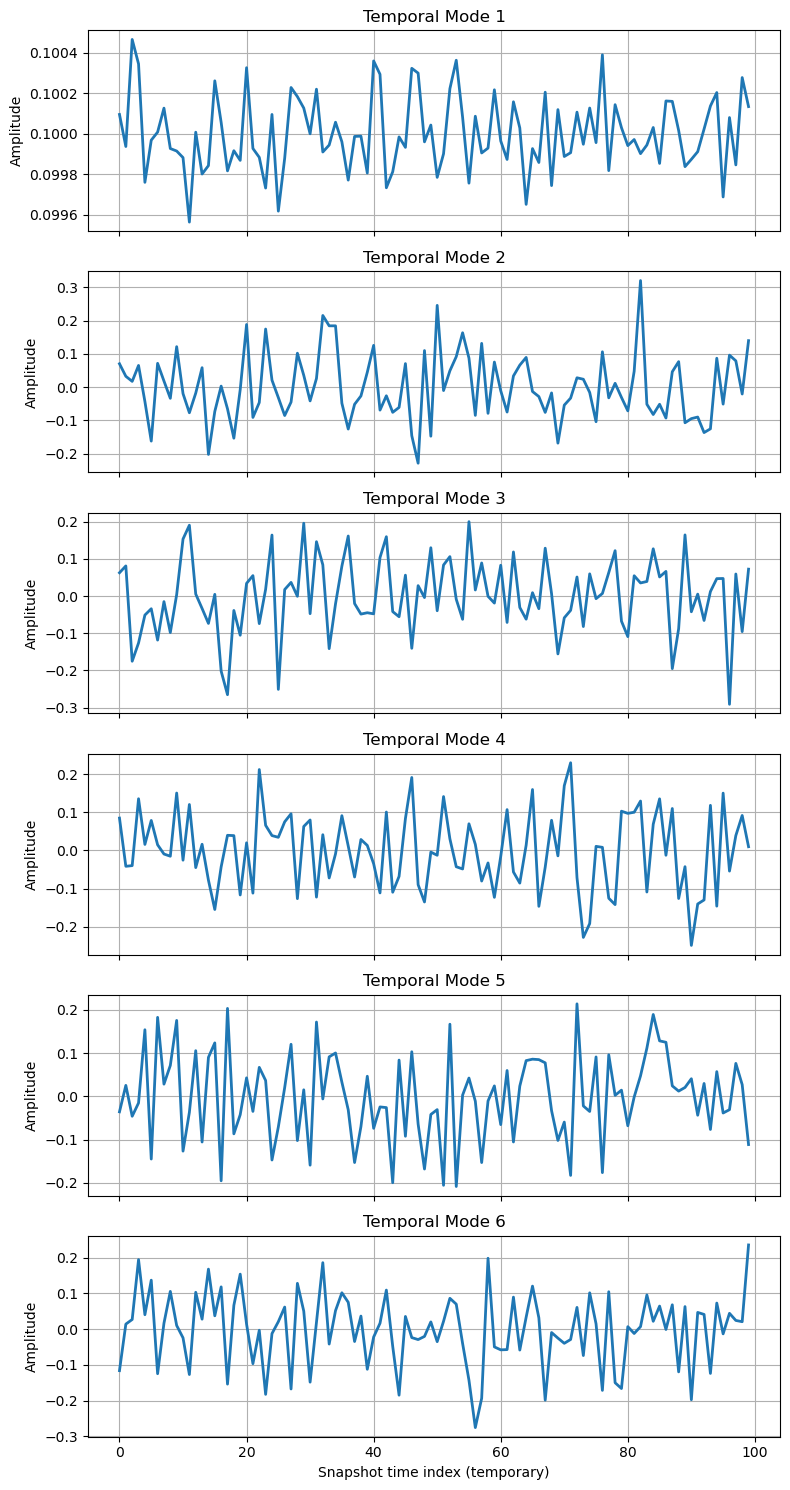

Energy Captured:
1.0


In [143]:
if __name__ == "__main__":
    # Read Variables
    inputs = read_variables_to_globals("input_POD.txt")
    
    U, S, Vt, U_val, S_val, Vt_val = main(ProjectName, NumSS, NumModes)

    # Plot Singular Value Spectra
    plot_singular(S_val, 'Validation SV Power Spectra')
    plot_singular(S, 'Manual SV Power Spectra')

    # Plot Temporal modes
    plot_temporal_modes(Vt, NumModes)

    # Output Percentage of Energy Captured from k rank approximation
    e_cap = energy_captured(S, NumModes)
    print("Energy Captured:")
    print(e_cap)

    # TODO: Print the Modes to text files
